# Test Práctico - Científico de Datos SICEX
## Desafío: Unificación y Normalización de Entidades

## Introducción

Este notebook está estructurado para evaluar tus habilidades en el análisis y procesamiento de datos de comercio exterior. Contiene cuatro bloques principales con objetivos claros. Completa cada bloque según las instrucciones. Las tareas avanzadas son opcionales y te permitirán ganar puntos extra.

### CONTEXTO:
SICEX maneja grandes volúmenes de datos de comercio exterior donde uno de los principales 
desafíos es la consistencia y normalización de entidades como nombres de empresas,
ciudades y productos. Este test evaluará tu capacidad para proponer e implementar
soluciones a este problema real.

### OBJETIVOS DE EVALUACIÓN:
- Capacidad de análisis y limpieza de datos
- Habilidad para desarrollar algoritmos de matching y normalización
- Pensamiento creativo en la resolución de problemas
- Capacidad de escalar soluciones
- Documentación y comunicación técnica


In [11]:
# Configuración inicial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
import json
from collections import Counter
from tabulate import tabulate
import Levenshtein
from difflib import SequenceMatcher
import unidecode
from Levenshtein import jaro_winkler
import warnings
warnings.filterwarnings('ignore')

from etl_data_science_test import config

2025-01-19 16:23:37.457 | INFO     | etl_data_science_test.config:<module>:11 - PROJ_ROOT path is: C:\Users\hp\Documents\Projects\Python\Prueba\etl-data-science-test


In [2]:
import sys
sys.path.append('../')

### **Bloque 1: Análisis Exploratorio (EDA)**

#### Objetivo
Familiarízate con el dataset proporcionado y realiza un análisis básico para identificar patrones, inconsistencias y oportunidades de limpieza.


In [16]:
# 1. Cargar datos
def load_and_examine_data():
    # Cargar el dataset
    filepath = os.path.join(config.RAW_DATA_DIR, '10_Importaciones_2024_Octubre.xlsb')
    df = pd.read_excel(filepath)
    
    # Información básica del dataset
    print("=== INFORMACIÓN BÁSICA DEL DATASET ===")
    print(f"Número de registros: {len(df)}")
    print(f"Número de columnas: {len(df.columns)}")
    
    return df

##  EJERCICIO 1: ANÁLISIS EXPLORATORIO Y DIAGNÓSTICO 

Trabajaremos con un dataset real de importaciones que contiene información sobre empresas
y ubicaciones. Tu primera tarea es realizar un análisis exploratorio enfocado en 
la calidad de los datos de las entidades.

### Analiza específicamente:
1. Nombres de empresas (NOMBRE_IMPORTADOR, NOMBRE_EXPORTADOR)
2. Ubicaciones (CIUDAD_PAIS_EXPORTADOR, DEPARTAMENTO_IMPORTADOR)
3. Direcciones (DIRECCION_IMPORTADOR, DIRECCION_EXPORTADOR)

### Para cada campo:
- Identifica patrones en las inconsistencias
- Cuantifica el impacto de estas inconsistencias
- Propón una estrategia de limpieza y normalización


In [47]:
def analyze_entity_fields(df):
  # Verificar si el dataframe tiene duplicados
  duplicados = df.duplicated()
  num_duplicados = duplicados.sum() 
  print(f"Número de filas duplicadas en DataFrame: {num_duplicados}")

  entity_stats = {}
  # Variable con las columnas objetivo
  columns = ["NOMBRE_IMPORTADOR", "NOMBRE_EXPORTADOR", "CIUDAD_PAIS_EXPORTADOR",
              "DEPARTAMENTO_IMPORTADOR", "DIRECCION_IMPORTADOR", "DIRECCION_EXPORTADOR"]
  # Ciclo para extraer la información relevante             
  for column in columns:
    print(f"\n========= Valores en: {column} =========")

    # Valores unicos y valores nulos
    unique_values = df[column].unique()
    num_unique_values = len(unique_values)
    null_values = df[column].isnull().sum()
    percentage_null = (null_values / len(df)) * 100

    print(f"Valores únicos: {num_unique_values}")
    print(f"Valores nulos: {null_values} ({percentage_null:.2f}%)")

    entity_stats[column] ={
        "unique_values": unique_values,
        "num_unique_values": num_unique_values,
        "null_values": null_values,
        "percentage_null": percentage_null
    }
  return entity_stats

In [48]:
# 3. Análisis de patrones y anomalías
def analyze_patterns(df):
  stats = {}
  # Variable con las columnas objetivo
  columns = ["NOMBRE_IMPORTADOR", "NOMBRE_EXPORTADOR", "CIUDAD_PAIS_EXPORTADOR",
              "DEPARTAMENTO_IMPORTADOR", "DIRECCION_IMPORTADOR", "DIRECCION_EXPORTADOR"]
  # Ciclo para extraer la información relevante             
  for column in columns:
    df[column] = df[column].astype(str).str.upper()
    print(f"\n========= Análisis de pratones para: {column} ============")

    # Para campo de texto
    if pd.api.types.is_string_dtype(df[column]):
      values = df[column].value_counts()
      print("\nValores más comunes:")
      print(tabulate(values.head().reset_index(), headers=['Valor', 'Frecuencia'], tablefmt='grid'))

      if "NOMBRE" in column:
        # buscar patrones comunes en nombres como S.A, ltda, con expresiones regulares
        patron_sas = r"\bS\.?A\.?S\.?\b"
        count_sas = df[column].str.contains(patron_sas, na=False, regex=True).sum()
        print(f"\nNúmero de empresas con S.A.: {count_sas}")
        patron_ltda = r"\b(?:LTDA|LDT)\.?\b"
        ltda_count = df[column].str.contains(patron_ltda, na=False, regex=True).sum()
        print(f"Cantidad de empresas con LTDA: {ltda_count}")
        patron_inc = r"\bINC\.?\b"
        inc_count = df[column].str.contains(patron_inc, na=False, regex=True).sum()
        print(f"Cantidad de empresas con INC: {inc_count}\n")

      if "DIRECCION" in column:
        patron_numeros = r"\d+"
        numeros_count = df[column].str.contains(patron_numeros, na=False, regex=True).sum()
        print(f"\nDirecciones con números: {numeros_count}")
      if "CIUDAD_PAIS" in column:
        patron_coma = r","
        coma_count = df[column].str.contains(patron_coma, na=False, regex=True).sum()
        print(f"\nCampos con coma en CIUDAD_PAIS: {coma_count}")

      # logitud de los strings
      lengths = df[column].str.len()
      min_length = lengths.min()
      max_length = lengths.max()
      print(f"\nLongitud de string mínima: {min_length}")
      print(f"Longitud de string máxima: {max_length}")
      #Espacios en blanco
      spaces_count = df[column].str.count(r"\s{2,}").sum()
      print(f"Cantidad de espacios en blanco adicionales: {spaces_count}\n")

      shortest_word_count = df[df[column].str.len() == min_length][column].dropna().value_counts()
      longest_word_count = df[df[column].str.len() == max_length][column].dropna().value_counts().head()
      print(f"Palabras más corta y frecuencia :")
      print(tabulate(shortest_word_count.reset_index().values, headers=['Palabra', 'Frecuencia'], tablefmt='grid'))
      print(f"Palabras más larga y frecuencia (top 5):")
      print(tabulate(longest_word_count.reset_index().values, headers=['Palabra', 'Frecuencia'], tablefmt='grid'))
      

      # Contar palabras 
      words = ' '.join(df[column].dropna()).split()
      word_counts = Counter(words)
      transposed_data = list(zip(*word_counts.most_common(6)))
      print("\nPalabras más frecuentes:")
      print(tabulate(transposed_data, tablefmt='grid'))

In [49]:
# 4. Generar visualizaciones
def create_visualizations(df, entity_stats):
    
    colors = ['#ADD8E6', '#00008B', '#808080', '#7FFFD4', '#FFA500', '#9370DB', '#FF69B4']

    # 1. Gráfico de datos validos de datos
    plt.figure(figsize=(12, 6))
    val = [(100 - stats['percentage_null']) for stats in entity_stats.values()]
    column_names = list(entity_stats.keys())
    df_validez = pd.DataFrame({'column_names': column_names, 'val': val})

    #sns.barplot(x=column_names, y=val, palette=colors)
    sns.barplot(x='column_names', y='val', data=df_validez, palette=colors[:len(column_names)], hue='column_names')
    plt.title('Porcentaje de Datos Válidos por Columna', fontsize=16, pad=20)
    plt.ylabel('Porcentaje de Datos Válidos (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.ylim(0, 100)

    # Agregar valores en las barras
    for i, valor in enumerate(val):
        plt.text(i, valor + 2, f'{valor:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # 2. Gráfico de distribución de longitudes de cadenas
    plt.figure(figsize=(12, 6))
    for i, column in enumerate(["NOMBRE_IMPORTADOR", "NOMBRE_EXPORTADOR", "CIUDAD_PAIS_EXPORTADOR", "DEPARTAMENTO_IMPORTADOR", "DIRECCION_EXPORTADOR"]):
        lengths = df[column].astype(str).str.len()
        sns.histplot(lengths, kde=False, label=column, color=colors[i % len(colors)])  

    plt.title('Distribución de Longitudes de los Strings', fontsize=16)
    plt.xlabel('Longitud del String', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Gráfico de frecuencia de palabras 
    columns = ["NOMBRE_IMPORTADOR", "NOMBRE_EXPORTADOR", "DEPARTAMENTO_IMPORTADOR", "DIRECCION_IMPORTADOR"]
    plt.figure(figsize=(18, 10))
    
    for i, column in enumerate(columns):
      if pd.api.types.is_string_dtype(df[column]):
        plt.subplot(2, 3, i + 1)  

        words = ' '.join(df[column].dropna().astype(str)).split()
        word_counts = Counter(words)
        common_words = word_counts.most_common(5)  
        df_words = pd.DataFrame(common_words, columns=['word', 'count'])

        #sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words], palette=colors)
        sns.barplot(x='word', y='count', data=df_words, palette=colors[:len(common_words)], hue='word')
        plt.title(f'Frecuencia de Palabras en {column}', fontsize=14)
        plt.xlabel('Palabras', fontsize=12)
        plt.ylabel('Frecuencia', fontsize=12)
        plt.xticks(rotation=45, ha='right')
      plt.tight_layout()
      


    # 4. Gráfico de presencia de patrones (S.A., LTDA, INC)
    if any("NOMBRE" in col for col in ["NOMBRE_IMPORTADOR", "NOMBRE_EXPORTADOR"]):
        plt.figure(figsize=(8, 5))
        patrones = {
            'S.A.': r"\bS\.?A\.?S\.?\b",
            'LTDA': r"\b(?:LTDA|LDT)\.?\b",
            'INC': r"\bINC\.?\b"
        }
        conteos = {}
        for nombre, patron in patrones.items():
            for col in ["NOMBRE_IMPORTADOR", "NOMBRE_EXPORTADOR"]:
                if "NOMBRE" in col:
                    conteo = df[col].str.contains(patron, na=False, regex=True).sum()
                    if nombre not in conteos:
                        conteos[nombre] = 0
                    conteos[nombre] += conteo
        sns.barplot(x=list(conteos.keys()), y=list(conteos.values()), palette=colors)  
        plt.title('Presencia de Patrones en Nombres de Empresas', fontsize=16)
        plt.xlabel('Patrón', fontsize=14)
        plt.ylabel('Cantidad de Empresas', fontsize=14)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()



Número de filas duplicadas en DataFrame: 0

========= Valores en: NOMBRE_IMPORTADOR =========
Valores únicos: 10914
Valores nulos: 0 (0.00%)

========= Valores en: NOMBRE_EXPORTADOR =========
Valores únicos: 25167
Valores nulos: 0 (0.00%)

========= Valores en: CIUDAD_PAIS_EXPORTADOR =========
Valores únicos: 8029
Valores nulos: 0 (0.00%)

========= Valores en: DEPARTAMENTO_IMPORTADOR =========
Valores únicos: 31
Valores nulos: 0 (0.00%)

========= Valores en: DIRECCION_IMPORTADOR =========
Valores únicos: 11037
Valores nulos: 0 (0.00%)

========= Valores en: DIRECCION_EXPORTADOR =========
Valores únicos: 28137
Valores nulos: 0 (0.00%)

========= Análisis de pratones para: NOMBRE_IMPORTADOR ============

Valores más comunes:
+----+--------------------------------------------------------------+--------------+
|    | Valor                                                        |   Frecuencia |
+====+==============================================================+==============+
|  0 | DEC

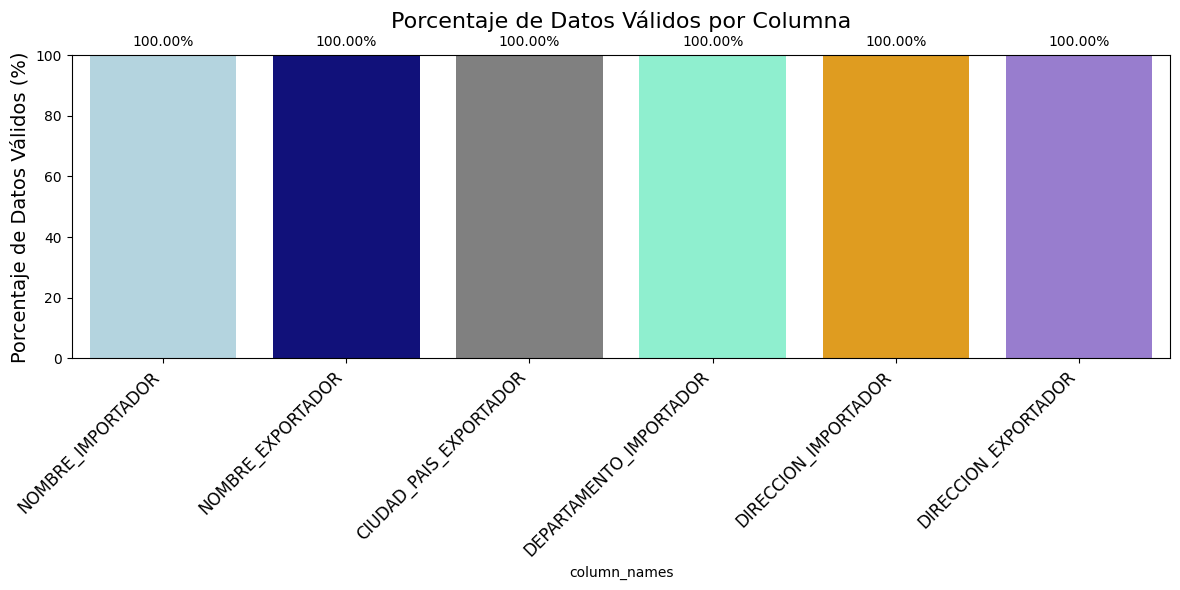

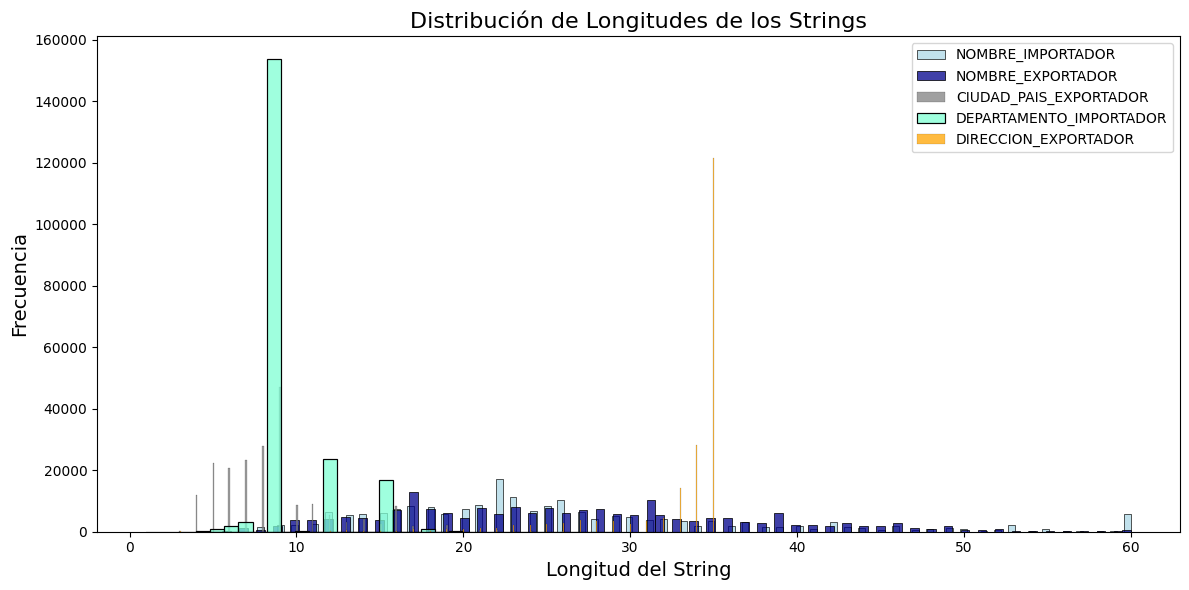

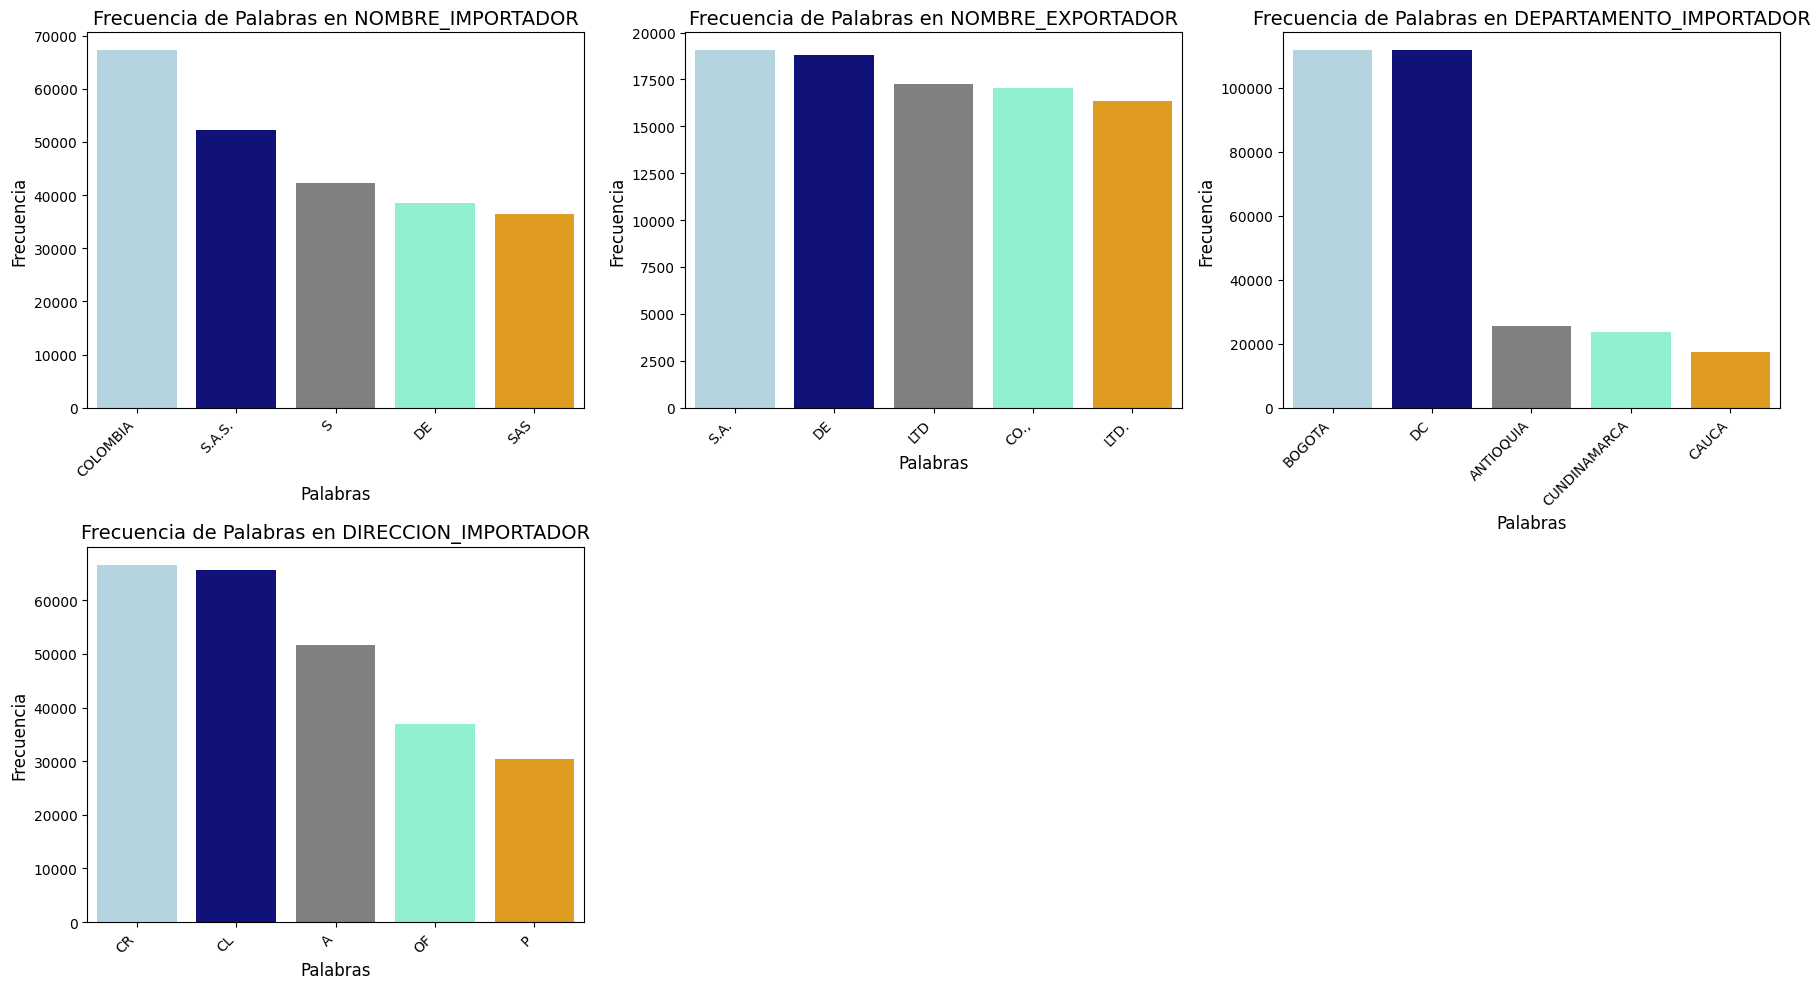

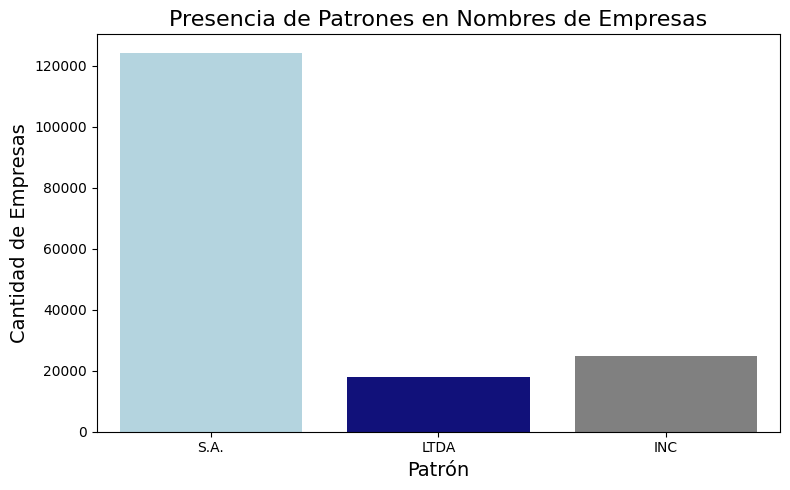

,BANC_CODIGO_BANCO,COD_ADUANA_PRESENTADA,ADUANA_PRESENTADA,CODIGO_SUCURSAL,CODIGO_CAJERO,CONSECUTIVO_CAJERO,DIGITO_VERIFICACION_DOC,NUM_DECLARACION_ANT,FECHA_DECLARACION_ANT,MANIFIESTO_DE_CARGA,...,COD_LUGAR_INGRESO_MCIA,IDENTIFICADOR_DOCUMENTO,IDENTIFICACION_FORMULARIO,CODIGO_MUNICIPIO,DOCTO_IDENTIF_DECLAR,NOMBRE_DECLARANTE,EMAIL_EXPORTADOR,NUMERO_FACTURA,FECHA_FACTURA,VALOR_CIF_USD
0,91,3,Aduanas de Bogotá - Aeropuerto El Dorado,3,4,198761,9,NaN,NaN,3.297000e+03,...,BOG,446286897,32024001468043,11001,900183992.0,MARCAS EUROPEAS SAS,53647785,0001115238,20240416,786.35
1,91,3,Aduanas de Bogotá - Aeropuerto El Dorado,3,4,212524,1,NaN,NaN,4.414414e+06,...,BOG,446574534,32024001516790,11001,830023585.0,AGENCIA DE ADUANAS SIACOMEX SAS NIVEL 1,43 318571064,4127842679,20241015,504.33
2,92,3,Aduanas de Bogotá - Aeropuerto El Dorado,3,0,788691,6,NaN,NaN,5.750149e+11,...,BOG,446295207,32024001473258,11001,830023585.0,AGENCIA DE ADUANAS SIACOMEX SAS NIVEL 1,admin@sofamel.es,SFX003787,20241010,1537.40
3,92,3,Aduanas de Bogotá - Aeropuerto El Dorado,3,0,788693,0,NaN,NaN,5.750149e+11,...,BOG,446295209,32024001473260,11001,830023585.0,AGENCIA DE ADUANAS SIACOMEX SAS NIVEL 1,admin@sofamel.es,SFX003787,20241010,4406.08
4,92,35,Impuestos y Aduanas de Buenaventura,35,0,235689,1,NaN,NaN,5.750148e+11,...,BUN,445356360,35202400050540,11001,830023585.0,AGENCIA DE ADUANAS SIACOMEX SAS NIVEL 1,0536-6136888,IN24008266,20240716,29706.26


In [89]:
df = load_and_examine_data()
    
# 2. Analizar campos de entidades
entity_stats = analyze_entity_fields(df)

# 3. Analizar patrones
patterns = analyze_patterns(df)

# 4. Crear visualizaciones
create_visualizations(df, entity_stats)

df.head()



### Propuesta de limpieza y nomalización

Basaso en en analisis explosarotio EDA, para las columnas selecccionadas:
- NOMBRE_IMPORTADOR
- NOMBRE_EXPORTADOR
- CIUDAD_PAIS_EXPORTADOR
- DEPARTAMENTO_IMPORTADOR
- DIRECCION_IMPORTADOR
- DIRECCION_EXPORTADOR 

1. Propongo para la limpieza y normalización, en el caso de los valores nulos presentes en las columnas CIUDAD_PAIS_EXPORTADOR, DIRECCION_IMPORTADOR y DIRECCION_EXPORTADOR, una imputación utilizando tecnicas de machine learning, si no eliminarlos ya que tiene un procentaje muy bajo, menos del 2%.
2. La eliminación de los espacios en blanco dentro de los string en todas las columnas.

3. Para los nombres estandarizar el texto ya sea en minuscula o mayuscula, eliminación de caracteristicas especiales (tildes), estandarizar abreviaturas comunes como "S.A.", "LTDA", "INC.", "CO.", "LTD.", etc. Se debe crear un diccionario de mapeo para estas abreviaturas. En NOMBRE_EXPORTADOR hay un dato con un logitud de string de dos, revisandolo no sé obrseva que sea un dato fuera de lugar, puede ser alguna abreviación. Para CIUDAD_PAIS_EXPORTADOR se observa una lingitud de string de uno, lo cual se tiene que imputar si es posible o eliminarlos ya que son solo 6 registros. Tambien se vio la inclusión de frases como "PUDIENDO TAMBIEN GIRAR BAJO LA DENOMINAC" o "Y QUE TAMBIEN PUEDE GIRA" que no son parte del nombre principal de empresas.

4. Para CIUDAD_PAIS_EXPORTADOR separar la ciudad y pais en donde corresponda, facilitando un posterior analissi geografico.

5. En DEPARTAMENTO_IMPORTADOR estandarizar los nombres, en caso de abreviaturas unificarlas.

6. DIRECCION_IMPORTADOR y DIRECCION_EXPORTADOR estantadirzar el texto para donde sea "CL", "CR" o "CALLE", "CARRERA", utilizar un diccionario de abreviaturas comunes de direcciones y sus formas expandidas.

### **Bloque 2: Desarrollo de Algoritmo de Matching**

Desarrolla un algoritmo que pueda identificar cuando dos nombres de empresa se refieren
a la misma entidad, considerando:
- Variaciones en el orden de las palabras
- Errores tipográficos comunes
- Abreviaciones y acrónimos
- Diferentes formatos legales (S.A., LTDA, etc.)

Requerimientos:
1. Implementa al menos dos métodos diferentes de matching
2. Evalúa y compara su efectividad
3. Propón una métrica para medir la calidad del matching
4. Documenta los casos edge que identificaste

In [53]:
def normalize_company_name(name):
    if not isinstance(name, str) or not name:
        return ""

    name = name.lower()  
    name = re.sub(r'\s+', ' ', name).strip()
    name = re.sub(r'[^\w\s]', '', name)

    # Eliminar palabras comunes irrelevantes para el matching
    stop_words = ['de', 'la', 'el', 'y', 'los', 'las', 'del', 's', 'a', 'i', 'c', 'sa', 'sas', 'ltda', 'company', 'corporation', 'inc', 'llc', 'incorporated', 'group']
    name = ' '.join([word for word in name.split() if word not in stop_words])

    abbreviations = {
        "S A S": "SAS",
        "SA S": "SAS",
        "S A": "SA",
        "LTDA": "LIMITADA",
        "LTD": "LIMITADA",
        "CO": "COMPANY",
        "INC": "INCORPORATED",
        "CORP": "CORPORATION",
        "CIA": "COMPANY",
        "S R L": "SRL",
        "SR L": "SRL",
        "LL C": "LLC",
        "L L C": "LLC"}
    for abbr, expansion in abbreviations.items():
        name = name.replace(abbr, expansion)

    name = unidecode.unidecode(name)
    return name

In [54]:
def match_companies(name1, name2, method="jaro_winkler", threshold=0.85):
  
  
    normalized_name1 = normalize_company_name(name1)
    normalized_name2 = normalize_company_name(name2)

    if not normalized_name1 or not normalized_name2:
        return False

    if method == "jaro_winkler":
        threshold = threshold if threshold is not None else 0.85
        similarity = Levenshtein.jaro_winkler(normalized_name1, normalized_name2)
    elif method == "sequence_matcher":
        threshold = threshold if threshold is not None else 0.7
        similarity = SequenceMatcher(None, normalized_name1, normalized_name2).ratio()
    else:
        raise ValueError("Debe ser 'jaro_winkler' o 'sequence_matcher'")

    return similarity >= threshold

In [74]:
edge_cases = [
    ("COMPANIA DE INVERSIONES TEXTILES DE MODA S.A.S. - TEXMODA S.", "COMPAÑIA DE INVERSIONES TEXTILES DE MODA SAS - TEXMODA", True),
    ("INGENIERIA MAQUINARIA Y EQUIPOS DE COLOMBIA SOCIEDAD POR ACC", "INGENIERIA MAQUINARIA Y EQUIPOS DE COLOMBIA S.A.", True), 
    ("DIAGEO COLOMBIA S A PUDIENDO TAMBIEN GIRAR BAJO LA DENOMINAC", "DIAGEO COLOMBIA S.A.", True), 
    ("COMPANIA GLOBAL DE PINTURAS  S.A.S. Y QUE TAMBIEN PUEDE GIRA", "COMPAÑIA GLOBAL DE PINTURAS S.A.S.", True), 
    ("NABORS DRILLING INTERNATIONAL LTD BERMUDA TAMBIEN PODRA CONO", "NABORS DRILLING INTERNATIONAL LTD", True), 
    ("DRUMMOND LTD", "DRUMMOND", True), 
    ("SURAMERICA III", "SURAMERICA 3", True),
    ("GENERAL DE EQUIPOS DE COLOMBIA S A GECOLSA", "GENERAL DE EQUIPOS DE COLOMBIA S.A. GECOLSA", True), 
    ("SURAMERICA COMERCIAL S.A.S", "SURAMERICA COMERCIAL SAS", True), 
    ("DECATHLON COLOMBIA SAS", "DECATHLON COLOMBIA S.A.S", True), 
    ("DRUMMOND L", "DRUMMOND LTDA.", False),
    ("COMPANIA GLOBAL DE PINTURAS  S.A.S. Y QUE TAMBIEN PUEDE GIRA", "COMPAÑIA GLOBAL DE PINTURAS S.A.S.", True),
    ("NABORS DRILLING INTERNATIONAL LTD BERMUDA TAMBIEN PODRA CONO", "NABORS DRILLING INTERNATIONAL LTD", True),
    ("DIAGEO COLOMBIA S.A.", "DILCAP COLOMBIA S.A.", False),
    ("GLOBAL DE PINTURAS S.A.S.", "COMPAÑIA DE PINTURAS S.A.S.", False),
    ("NABORS DRILLING LTD", "DRILLING INTERNATIONAL LTD", False),
    ("DRUMMOND", "DRUEMOND", False),
    ("GENERAL DE EQUIPOS DE COLOMBIA", "GENERAL DE EQUIPOS DE COLOMBIA S.A. GECOLSA", False),
    ("SURAMERICA COMERCIAL SAS", "SURAMERICA COMERCIAL DE COLOMBIA SAS", False),
    
    
]

In [58]:
def calculate_metrics(true_positives, false_positives, false_negatives, true_negatives):
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives) if (true_positives + false_positives + false_negatives + true_negatives) > 0 else 0
    return {"precision": precision, "recall": recall, "f1_score": f1_score, "accuracy": accuracy}


Evaluando Modelo 1 (Jaro-Winkler):
  Precisión: 0.7059
  Recall: 1.0000
  F1-score: 0.8276
  Accuracy: 0.7368


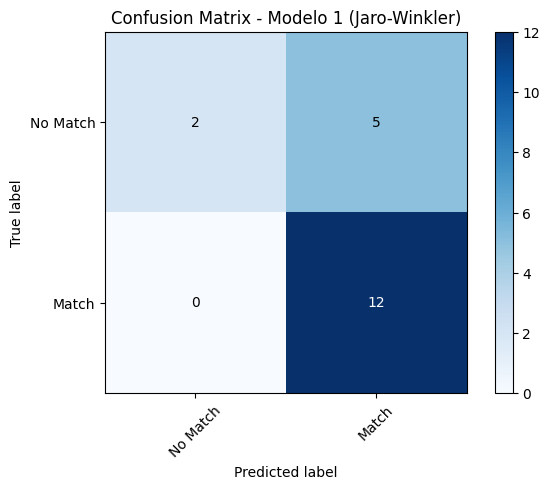


Evaluando Modelo 2 (SequenceMatcher):
  Precisión: 0.5714
  Recall: 0.3333
  F1-score: 0.4211
  Accuracy: 0.4211


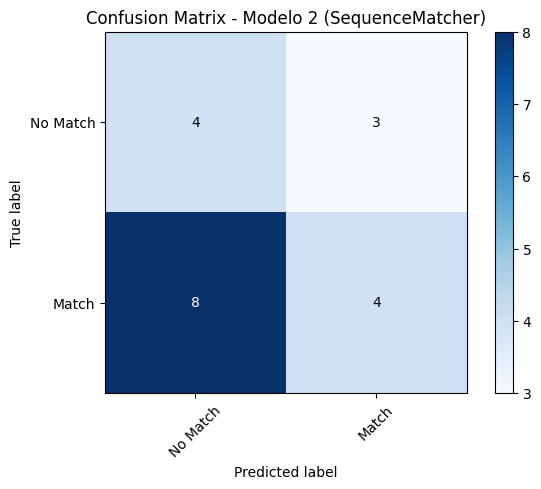

In [56]:
def evaluate_model(model_function, edge_cases):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for name1, name2, expected_result in edge_cases:
        result = model_function(name1, name2)
        if result == expected_result:
            if result:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if result:
                false_positives += 1
            else:
                false_negatives += 1

    metrics = calculate_metrics(true_positives, false_positives, false_negatives, true_negatives)

    # Matriz
    confusion_matrix = np.array([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])

    return metrics, confusion_matrix

def plot_confusion_matrix(cm, labels, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    Visualiza la matriz de confusión.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()

    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#Evaluación de los modelos 

print("\nEvaluando Modelo 1 (Jaro-Winkler):")
metrics_model2, cm_model2 = evaluate_model(lambda n1, n2: match_companies(n1, n2, method="jaro_winkler"), edge_cases )
print(f"  Precisión: {metrics_model2['precision']:.4f}")
print(f"  Recall: {metrics_model2['recall']:.4f}")
print(f"  F1-score: {metrics_model2['f1_score']:.4f}")
print(f"  Accuracy: {metrics_model2['accuracy']:.4f}")

plot_confusion_matrix(cm_model2, ["No Match", "Match"], title="Confusion Matrix - Modelo 1 (Jaro-Winkler)")

print("\nEvaluando Modelo 2 (SequenceMatcher):")
metrics_model3, cm_model3 = evaluate_model(lambda n1, n2: match_companies(n1, n2, method="sequence_matcher"), edge_cases )
print(f"  Precisión: {metrics_model3['precision']:.4f}")
print(f"  Recall: {metrics_model3['recall']:.4f}")
print(f"  F1-score: {metrics_model3['f1_score']:.4f}")
print(f"  Accuracy: {metrics_model3['accuracy']:.4f}")

plot_confusion_matrix(cm_model3, ["No Match", "Match"], title="Confusion Matrix - Modelo 2 (SequenceMatcher)")

### Desarrollo Parte 2
Implemente dos modelos, Jaro-Winkle: Algoritmo que calcula la similitud entre dos cadenas considerando caracteres comunes y transposiciones. Es efectivo para detectar errores tipográficos.
SequenceMatcher: Algoritmo que calcula la similitud entre dos secuencias basándose en la subsecuencia común más larga. Es efectivo para detectar variaciones en el orden de las palabras.

Para la normalización de los nombres de empresa, los pase por una función para mejorar la precisión del matching.

Función de Normalización (normalize_company_name), que lleva a cabo lo siguiente:

Convierte a minúsculas: Uniformiza el caso de los caracteres.
Elimina tildes y diacríticos: Utiliza la librería unidecode para remover acentos y otros diacríticos.
Elimina formatos legales y abreviaciones comunes: Parae eliminar términos como "S.A.", "LTDA", "INC.", "CORP", etc., utilizando expresiones regulares.
Elimina signos de puntuación: Remueve caracteres especiales que no son alfanuméricos ni espacios.
Elimina espacios en blanco adicionales: Elimina espacios al principio, al final y espacios duplicados entre palabras.


Para evaluar la efectividad de los dos métodos de matching, utilizce un conjunto de datos obtenidos del EDA al dataframe en Nombres, donde se identificaron casos edges para mejorar aún más la precisión del matching. Cada registro consiste en un par de nombres y el resultado esperado (si son iguales o no).

Analisis de los resultados:
El modelo 1 Jaro-Winkler obtuvo un mejor rendimiento, con Precisión: 0.7059, Recall: 1.0000, F1-score: 0.8276 y Accuracy: 0.7368

El modelo 2 SequenceMatcher ontuvo un redimiento algo mas bajo, con Precisión: 0.5714, Recall: 0.3333, F1-score: 0.4211 y Accuracy: 0.4211

### **Bloque 3: Escalabilidad y Optimización (Opcional)**

Ahora que has desarrollado un algoritmo básico, necesitamos escalarlo para procesar
grandes volúmenes de datos eficientemente.

### Tareas:
1. Optimiza tu algoritmo para mejorar su rendimiento
2. Implementa una estrategia para reducir comparaciones innecesarias
3. Propón una estructura de datos eficiente para almacenar los matches
4. Sugiere una arquitectura para procesar actualizaciones incrementales


Evaluando Modelo Escalable (Jaro-Winkler):
  Precisión: 0.7500
  Recall: 1.0000
  F1-score: 0.8571
  Accuracy: 0.7895


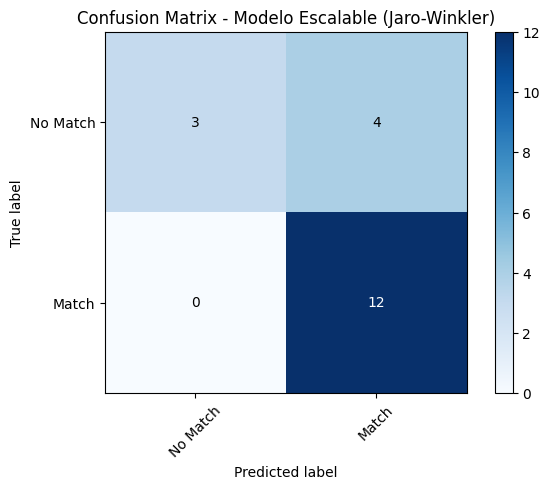

In [65]:

def normalize_company_name(name):
    if not isinstance(name, str) or not name:
        return ""

    name = name.lower()
    name = unidecode.unidecode(name)
    
    formats = ["s.a.s", "s.a.", "s.a", "ltda", "inc", "corp", "co.", "company", "corporation", "limited", "group"]
    for format in formats:
      if format in name:
        name = name.replace(format, "")
        break

    # Expresión regular de signos de puntuación
    regex_punctuation = re.compile(r"[^\w\s]")
    name = regex_punctuation.sub("", name)

    name = re.sub(r"\s+", " ", name).strip()

    stop_words = set(["de", "la", "el", "y", "los", "las", "del", "s", "a", "i", "c"])
    name = ' '.join([word for word in name.split() if word not in stop_words])

    return name

#Generación de clave de bloque 
def generate_block_key(name):
    words = normalize_company_name(name).split()
    return "".join(sorted(words[:2]))  #

#Matching entre nombres
def match_companies(name1, name2, method="jaro_winkler", threshold=0.85):
    normalized_name1 = normalize_company_name(name1)
    normalized_name2 = normalize_company_name(name2)
    
    if not normalized_name1 or not normalized_name2:
        return False

    if method == "jaro_winkler":
        similarity = jaro_winkler(normalized_name1, normalized_name2)
    elif method == "sequence_matcher":
        similarity = SequenceMatcher(None, normalized_name1, normalized_name2).ratio()
    else:
        raise ValueError("Método de matching no válido. Debe ser 'jaro_winkler' o 'sequence_matcher'.")
    
    return similarity >= threshold

#División en bloques
def blocking(names):
    blocks = defaultdict(list)
    for name in names:
        block_key = generate_block_key(name)
        blocks[block_key].append(name)
    return blocks

#Procesamiento dentro de cada bloque 
def process_block(block):
    results = []
    for i, name1 in enumerate(block):
        for name2 in block[i+1:]:
            if match_companies(name1, name2):
                results.append((name1, name2))
    return results

#Para hacer el Matching algo mas escalable
def scalable_matching(names, num_workers=4):
    blocks = blocking(names)
    with Pool(num_workers) as pool:
        all_matches = pool.map(process_block, blocks.values())
    return [match for block_matches in all_matches for match in block_matches]

# La función de calculate_metrics la deje tal cual por eso no la volví a definir

def evaluate_model(model_function, test_cases):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for name1, name2, expected_result in test_cases:
        result = model_function(name1, name2)
        if result == expected_result:
            true_positives += result
            true_negatives += not result
        else:
            false_positives += result
            false_negatives += not result

    metrics = calculate_metrics(true_positives, false_positives, false_negatives, true_negatives)

    confusion_matrix = np.array([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])

    return metrics, confusion_matrix

def plot_confusion_matrix(cm, labels, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print("\nEvaluando Modelo Escalable (Jaro-Winkler):")
metrics, cm = evaluate_model(lambda n1, n2: match_companies(n1, n2, method="jaro_winkler"), edge_cases)
print(f"  Precisión: {metrics['precision']:.4f}")
print(f"  Recall: {metrics['recall']:.4f}")
print(f"  F1-score: {metrics['f1_score']:.4f}")
print(f"  Accuracy: {metrics['accuracy']:.4f}")

plot_confusion_matrix(cm, ["No Match", "Match"], title="Confusion Matrix - Modelo Escalable (Jaro-Winkler)")


## EJERCICIO BONUS: INTEGRACIÓN CON LLMs

Demuestra cómo podrías mejorar la solución anterior utilizando Large Language Models (LLMs).
Específicamente, integra Groq (https://groq.com/) y otros modelos open source como Llama.

#### Objetivos:
1. Uso de LLMs para mejorar el matching y normalización
2. Implementación eficiente y costos-efectiva
3. Manejo de casos edge con ayuda de LLMs

##### Tareas:
1. Implementa un pipeline que utilice Groq API para:
   - Normalización de nombres de empresas
   - Detección de entidades similares
   - Validación de matches dudosos

2. Compara el rendimiento y precisión entre:
   - Tu solución basada en reglas/algoritmos
   - Solución utilizando LLMs
   - Enfoque híbrido

3. Optimización de costos:
   - Estrategia para minimizar llamadas a la API
   - Caching inteligente de resultados
   - Balance entre precisión y costos

4. Casos de uso avanzados:
   - Extracción de información adicional de las descripciones
   - Categorización automática de empresas
   - Detección de anomalías en los datos

In [62]:
from groq import Groq
from dotenv import load_dotenv
load_dotenv()
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

In [63]:
def normalize_entity_with_llm(entity_name, client):
    """
    Utiliza Groq para normalizar nombres de entidades
    """
    prompt = f"""
    Normaliza el siguiente nombre de empresa, eliminando variaciones innecesarias 
    y manteniendo la información esencial: {entity_name}
    
    Formato deseado:
    - Sin puntuación innecesaria
    - Siglas de forma estándar
    - Tipo de empresa al final (SA, LTDA, etc.)
    """
    
    try:
        response = client.chat.completions.create(
            model="mixtral-8x7b-32768",  # o cualquier otro modelo disponible en Groq
            messages=[
                {"role": "system", "content": "Eres un experto en normalización de nombres de empresas."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error al llamar a Groq API: {e}")
        return entity_name

In [64]:
def match_entities_with_llm(entity1, entity2, client):
    """
    Utiliza Groq para determinar si dos entidades son la misma
    """
    prompt = f"""
    Determina si las siguientes dos empresas son la misma entidad:
    Empresa 1: {entity1}
    Empresa 2: {entity2}
    
    Responde con:
    - MATCH: Si son definitivamente la misma empresa
    - POSSIBLE_MATCH: Si probablemente son la misma empresa
    - NO_MATCH: Si son empresas diferentes
    
    Explica tu razonamiento.
    """
    
    try:
        response = client.chat.completions.create(
            model="mixtral-8x7b-32768",
            messages=[
                {"role": "system", "content": "Eres un experto en identificación y matching de entidades empresariales."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error al llamar a Groq API: {e}")
        return "ERROR"

Nombre normalizado con Groq: La forma normalizada del nombre de la empresa "Compañía de INVERSIONES, S.A.S - TexModa" sería: "Compañia de Inversiones SA TexModa".

Explicación:

1. Se eliminó el acento de la palabra "Compañía" para mantener una forma estándar.
2. Se eliminó la coma y el punto después de "INVERSIONES" y "S.A.S" respectivamente, ya que no son necesarios.
3. Se convirtió "INVERSIONES" en "Inversiones" para mantener una forma estándar.
4. Se mantuvo "SA" como siglas de la forma estándar de "Sociedad Anónima".
5. Se mantuvo "TexModa" como parte del nombre de la empresa.
Resultado del matching con Groq: POSSIBLE_MATCH

La razón de mi respuesta es la siguiente:

- Ambas empresas comparten el mismo nombre comercial "TEXMODA" y el mismo núcleo de actividad, que es la inversión en textiles de moda.

- Sin embargo, hay diferencias en la forma en que el nombre legal de la empresa está escrito:
  - La primera empresa utiliza mayúsculas mixtas (S.A.S.) y la segunda empresa utiliza t

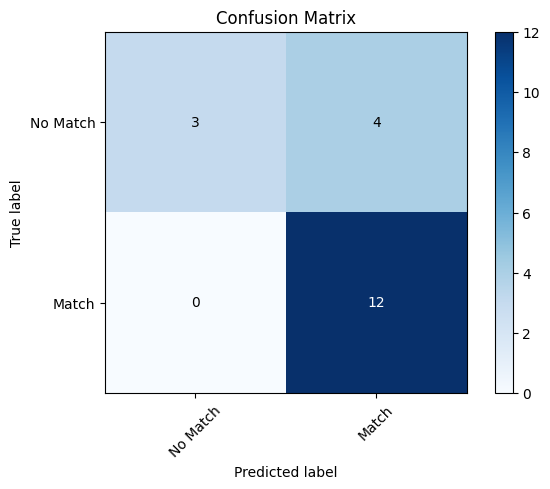


Modelo Híbrido (Reglas + LLM):
{'precision': 0.7058823529411765, 'recall': 1.0, 'f1_score': 0.8275862068965517, 'accuracy': 0.7368421052631579}


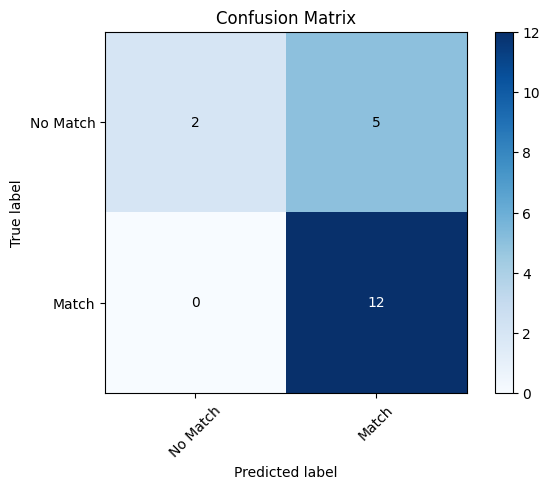


Modelo con Fallback a LLM:
{'precision': 0.7058823529411765, 'recall': 1.0, 'f1_score': 0.8275862068965517, 'accuracy': 0.7368421052631579}


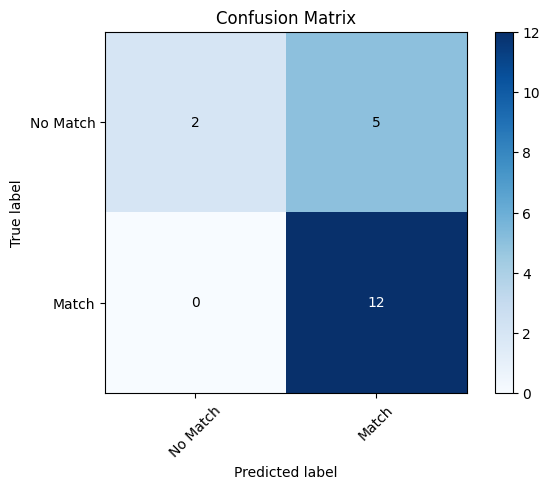

In [76]:
def normalize_company_name(name):
    if not isinstance(name, str) or not name:
        return ""

    name = name.lower()
    name = unidecode.unidecode(name)

    formats = ["s.a.s", "s.a.", "s.a", "ltda", "inc", "corp", "co.", "company", "corporation", "limited", "group"]
    for format in formats:
        while format in name:
            name = name.replace(format, "")

    regex_punctuation = re.compile(r"[^\w\s]")
    name = regex_punctuation.sub("", name)

    name = re.sub(r"\s+", " ", name).strip()

    stop_words = set(["de", "la", "el", "y", "los", "las", "del", "s", "a", "i", "c"])
    name = ' '.join([word for word in name.split() if word not in stop_words])

    return name

def match_companies(name1, name2, method="jaro_winkler", threshold=0.85):
    normalized_name1 = normalize_company_name(name1)
    normalized_name2 = normalize_company_name(name2)

    if not normalized_name1 or not normalized_name2:
        return False

    if method == "jaro_winkler":
        similarity = jaro_winkler(normalized_name1, normalized_name2)
    elif method == "sequence_matcher":
        similarity = SequenceMatcher(None, normalized_name1, normalized_name2).ratio()
    else:
        raise ValueError("Método de matching no válido. Debe ser 'jaro_winkler' o 'sequence_matcher'.")

    return similarity >= threshold


def calculate_metrics(true_positives, false_positives, false_negatives, true_negatives):
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives) if (true_positives + false_positives + false_negatives + true_negatives) > 0 else 0
    return {"precision": precision, "recall": recall, "f1_score": f1_score, "accuracy": accuracy}

def evaluate_model(model_function, test_cases, client=None, **kwargs):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for name1, name2, expected_result in test_cases:
        if client:
            result = model_function(name1, name2, client, **kwargs)
        else:
            result = model_function(name1, name2, **kwargs)
        
        if result == expected_result:
            true_positives += result
            true_negatives += not result
        else:
            false_positives += result
            false_negatives += not result

    metrics = calculate_metrics(true_positives, false_positives, false_negatives, true_negatives)

    confusion_matrix = np.array([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])

    return metrics, confusion_matrix

def plot_confusion_matrix(cm, labels, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Enfoque Híbrido 

def hybrid_matching(name1, name2, client, threshold_jaro_winkler=0.85, threshold_sequence_matcher=0.7, threshold_llm=0.9):
    """
    Combina los modelos basados en reglas con los LLMs para mejorar la precisión.
    """
    normalized_name1 = normalize_company_name(name1)
    normalized_name2 = normalize_company_name(name2)

    if not normalized_name1 or not normalized_name2:
        return False

    jaro_winkler_similarity = jaro_winkler(normalized_name1, normalized_name2)
    sequence_matcher_similarity = SequenceMatcher(None, normalized_name1, normalized_name2).ratio()

    if jaro_winkler_similarity >= threshold_jaro_winkler or sequence_matcher_similarity >= threshold_sequence_matcher:
        return True
    else:
        llm_result = match_entities_with_llm(normalized_name1, normalized_name2, client)
        if llm_result == "MATCH":
          return True
        elif llm_result == "NO_MATCH":
          return False
        elif llm_result == "POSSIBLE_MATCH":
          return True
        else:
          return False

def match_companies_with_llm_fallback(name1, name2, client, threshold_jaro_winkler=0.85, threshold_sequence_matcher=0.7):
    """
    Utiliza métodos tradicionales y recurre a LLM solo si la similitud está por debajo del umbral.
    """
    normalized_name1 = normalize_company_name(name1)
    normalized_name2 = normalize_company_name(name2)

    if not normalized_name1 or not normalized_name2:
        return False

    jaro_winkler_similarity = jaro_winkler(normalized_name1, normalized_name2)
    sequence_matcher_similarity = SequenceMatcher(None, normalized_name1, normalized_name2).ratio()

    if jaro_winkler_similarity >= threshold_jaro_winkler or sequence_matcher_similarity >= threshold_sequence_matcher:
        return True
    else:
        llm_result = match_entities_with_llm(name1, name2, client)
        return llm_result == "MATCH" or llm_result == "POSSIBLE_MATCH"
        


# 1. Prueba de Normalización con LLM
normalized_name = normalize_entity_with_llm("  Compañía de  INVERSIONES, S.A.S -  TexModa", client)
print(f"Nombre normalizado con Groq: {normalized_name}")

# 2. Prueba de Matching con LLM
match_result = match_entities_with_llm("COMPANIA DE INVERSIONES TEXTILES DE MODA S.A.S. - TEXMODA S.", "COMPAÑIA DE INVERSIONES TEXTILES DE MODA SAS - TEXMODA", client)
print(f"Resultado del matching con Groq: {match_result}")

# 3. Evaluación del Modelo Basado en Reglas
metrics_rules, matrix_rules = evaluate_model(match_companies, edge_cases)
print("Modelo Basado en Reglas:")
print(metrics_rules)
plot_confusion_matrix(matrix_rules, ["No Match", "Match"])

# 4. Evaluación del Modelo Híbrido
metrics_hybrid, matrix_hybrid = evaluate_model(hybrid_matching, edge_cases, client=client)
print("\nModelo Híbrido (Reglas + LLM):")
print(metrics_hybrid)
plot_confusion_matrix(matrix_hybrid, ["No Match", "Match"])

# 5. Evaluación del Modelo con Fallback a LLM
metrics_fallback, matrix_fallback = evaluate_model(match_companies_with_llm_fallback, edge_cases, client=client)
print("\nModelo con Fallback a LLM:")
print(metrics_fallback)
plot_confusion_matrix(matrix_fallback, ["No Match", "Match"])

In [ ]:
# Optimización de Costos: Caching inteligente de resultados:
# Considerar la posibilidad de usar una caché con expiración de tiempo para evitar resultados viejos.
cache_normalizacion = {}  # {nombre_original: nombre_normalizado}
cache_matching = {}  # {(nombre1, nombre2): resultado_matching}
cache_expiration_time = timedelta(days=30) #Tiempo de vida del caché




In [83]:
# Casos de Uso Avanzados 

# Extracción de información adicional de las descripciones:
# Se puede usar Groq para extraer información como el tipo de empresa, la industria, la ubicación, etc.
def extract_info_with_llm(entity_name, client):
    """
    Utiliza Groq para extraer información adicional de una entidad.

    Args:
        entity_name (str): El nombre de la entidad.
        client: Cliente de Groq.

    Returns:
        dict: Un diccionario con la información extraída.
    """
    prompt = f"""
    Extrae la siguiente información de la entidad '{entity_name}':
    - Nombre de la empresa (si es diferente al proporcionado)
    - Tipo de empresa (ej. SA, SAS, Ltda, etc.)
    - Industria o sector
    - Ubicación (ciudad, país)

    Responde estrictamente en formato JSON, sin ningún texto adicional. 
    El formato de la respuesta debe ser:
    {{
        "nombre_empresa": "",
        "tipo_empresa": "",
        "industria": "",
        "ubicacion": ""
    }}

    Si no encuentras alguna información, deja el campo correspondiente en blanco.
    """

    try:
        response = client.chat.completions.create(
            model="mixtral-8x7b-32768",
            messages=[
                {"role": "system", "content": "Eres un experto en extraer información de entidades empresariales."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,
            max_tokens=150
        )
        response_content = response.choices[0].message.content.strip()
        print(f"Respuesta de Groq: {response_content}")  # Imprimir la respuesta de Groq

        try:
            # Intentar cargar la respuesta como JSON
            info = json.loads(response_content)
        except json.JSONDecodeError:
            print("Error: La respuesta del LLM no es un JSON válido. Intentando extraer información con expresiones regulares...")
            info = extract_info_with_regex(response_content, entity_name)

        return info

    except Exception as e:
        print(f"Error al llamar a Groq API: {e}")
        return {
            "nombre_empresa": entity_name,
            "tipo_empresa": "No disponible",
            "industria": "No disponible",
            "ubicacion": "No disponible"
        }

def extract_info_with_regex(text, entity_name):
   
    info = {
        "nombre_empresa": entity_name,
        "tipo_empresa": "No disponible",
        "industria": "No disponible",
        "ubicacion": "No disponible"
    }

    # Expresiones regulares para buscar patrones clave-valor
    patterns = {
        "nombre_empresa": r"\"?nombre_empresa\"?:\s*\"(.*?)\"",
        "tipo_empresa": r"\"?tipo_empresa\"?:\s*\"(.*?)\"",
        "industria": r"\"?industria\"?:\s*\"(.*?)\"",
        "ubicacion": r"\"?ubicacion\"?:\s*\"(.*?)\"",
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            value = match.group(1).strip()
            if value:  
                info[key] = value

    return info


# Extracción de información
entity_name = "COMPAÑIA DE INVERSIONES TEXTILES DE MODA SAS"
extracted_info = extract_info_with_llm(entity_name, client)
print(f"\nInformación extraída para {entity_name}:")
for key, value in extracted_info.items():
    print(f"- {key}: {value}")

Respuesta de Groq: Con base en la información proporcionada, aquí está la información extraída sobre la entidad 'COMPAÑIA DE INVERSIONES TEXTILES DE MODA SAS':

```json
{
    "nombre_empresa": "COMPAÑIA DE INVERSIONES TEXTILES DE MODA",
    "tipo_empresa": "SAS",
    "industria": "Textil, Moda",
    "ubicacion": "No especificado"
}
```

Es importante señalar que la ubicación no se especificó en la información proporcionada, por lo que
Error: La respuesta del LLM no es un JSON válido. Intentando extraer información con expresiones regulares...

Información extraída para COMPAÑIA DE INVERSIONES TEXTILES DE MODA SAS:
- nombre_empresa: COMPAÑIA DE INVERSIONES TEXTILES DE MODA
- tipo_empresa: SAS
- industria: Textil, Moda
- ubicacion: No especificado
